In [2]:
import pandas as pd
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# set log level to Error
spark.sparkContext.setLogLevel("ERROR")

# Read the Excel file using Pandas
df_pandas = pd.read_excel("Online Retail.xlsx",na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame 
df_spark = spark.createDataFrame(df_pandas)

In [3]:
# Show the DataFrame
df_spark.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

### Data Summary

In [4]:
# Describe the DataFrame
df_spark.describe().show()


+-------+------------------+------------------+--------------------+------------------+-----------------+----------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+----------+-----------+
|  count|            541909|            541909|              541909|            541909|           541909|    541909|     541909|
|   mean|  559965.752026781|27623.240210938104|                 NaN|  9.55224954743324|4.611113626088897|       NaN|       null|
| stddev|13428.417280798658| 16799.73762842766|                 NaN|218.08115785023472|96.75985306117991|       NaN|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -80995|        -11062.06|   12346.0|  Australia|
|    max|           C581569|                 m|   wrongly sold sets|             80995|          

## Explore the data

### Percentage of missing values in each column

In [5]:
# percentage of missing values in each column of the DataFrame
from pyspark.sql.functions import col, count, isnan, when
# get columns excluding 'InvoiceDate'
cols = [col for col in df_spark.columns if col != 'InvoiceDate']


# count missing values in each column as a percentage of the total number of values and total number of values in each column
df_spark.select([count(when(~isnan(c), c)).alias(c) for c in cols]).show()
df_spark.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|   541909|   541909|     540455|  541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+---------+----------+-------+



+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|       1454|       0|        0|    135080|      0|
+---------+---------+-----------+--------+---------+----------+-------+



## Clean the data

In [6]:
import math

# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan(x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()
df_spark_filtered.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()


+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|          0|       0|        0|         0|      0|
+---------+---------+-----------+--------+---------+----------+-------+



## Percentage of Cancelled Orders

In [7]:

unique_invoice = df_spark_filtered.select('InvoiceNo').distinct().count()
cancelled_invoice_count = df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].startswith('C')).select('InvoiceNo').distinct().count()

# percentage of cancelled invoices
print("Percentage of cancelled invoices: ", (cancelled_invoice_count/unique_invoice)*100)

Percentage of cancelled invoices:  16.466876971608833


In [37]:

from pyspark.sql.functions import col
from pyspark.sql.functions import round
from pyspark.sql.functions import month

# create a new column called TotalCost
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", col("Quantity") * col("UnitPrice"))

# round the TotalCost column to 2 decimal places
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", round(df_spark_filtered.TotalCost, 2))
df_spark_filtered.show()




+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+---------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|TotalCost|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+---------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|     15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|     22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-

In [38]:
# Basket size
basket_price = df_spark_filtered.groupBy('CustomerID','InvoiceNo').agg({'TotalCost': 'sum'}).withColumnRenamed('sum(TotalCost)', 'TotalCost').sort('CustomerID')
basket_price.show()

+----------+---------+------------------+
|CustomerID|InvoiceNo|         TotalCost|
+----------+---------+------------------+
|   12346.0|   541431|           77183.6|
|   12346.0|  C541433|          -77183.6|
|   12347.0|   537626|            711.79|
|   12347.0|   542237|            475.39|
|   12347.0|   573511|1294.3200000000002|
|   12347.0|   549222|            636.25|
|   12347.0|   556201|            382.52|
|   12347.0|   562032|            584.91|
|   12347.0|   581180|224.82000000000002|
|   12348.0|   541998|227.43999999999997|
|   12348.0|   539318| 892.8000000000001|
|   12348.0|   548955|             367.0|
|   12348.0|   568172|             310.0|
|   12349.0|   577609|           1757.55|
|   12350.0|   543037|334.40000000000003|
|   12352.0|   567505|            366.25|
|   12352.0|   547390|160.32999999999998|
|   12352.0|   544156|296.49999999999994|
|   12352.0|   568699|            266.25|
|   12352.0|  C545329|            -463.8|
+----------+---------+------------

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22190|
|   mean|374.04532717440236|
| stddev|2018.4828692051483|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



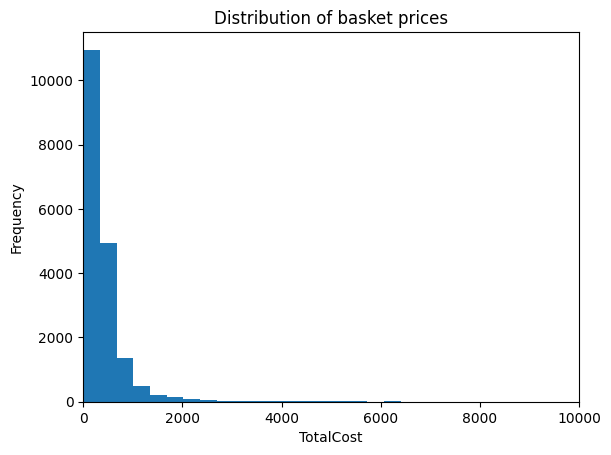

In [44]:
# Distribution of prices of baskets
basket_price.select('TotalCost').describe().show()

# construct a histogram of the basket prices
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# convert the PySpark DataFrame to Pandas DataFrame
basket_price_pd = basket_price.toPandas()

# plot the histogram
fig, ax = plt.subplots()
ax.hist(basket_price_pd['TotalCost'], bins=1000)
ax.set_xlabel('TotalCost')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of basket prices')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plt.gca()
ax.set_xlim([0, 10000])
plt.show()




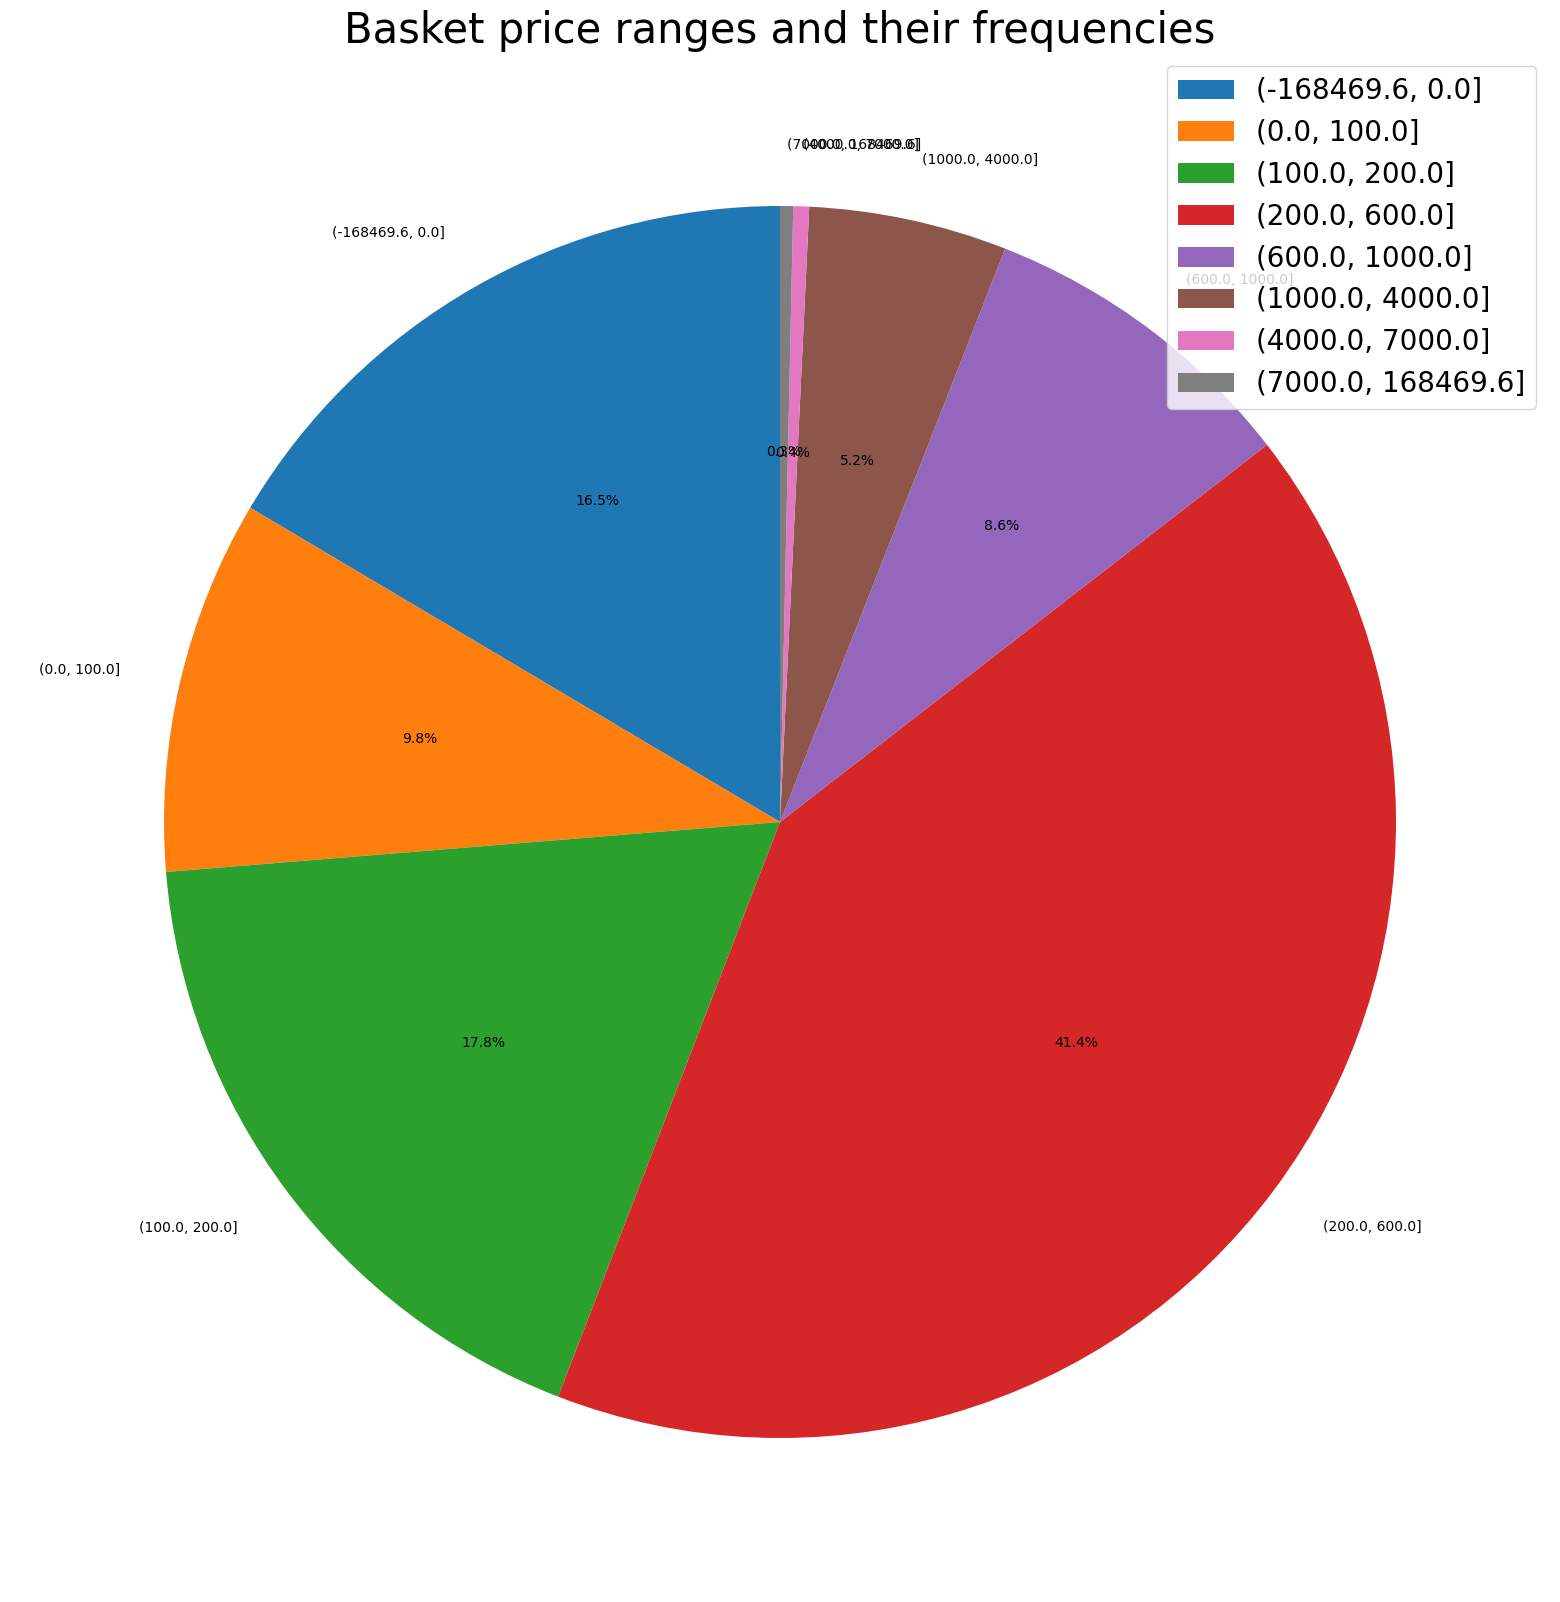

In [92]:
# construct ranges for the basket prices and count the number of baskets in each range
ranges = [-168469.6,0, 100, 200, 600, 1000, 4000, 7000,168469.6]
basket_price_range = basket_price_pd.groupby(pd.cut(basket_price_pd['TotalCost'], ranges)).count()
basket_price_range

# plot pie chart of the basket ranges and their frequencies
ax, fig = plt.subplots(figsize=(20, 20))
# plot pie chart
plt.pie(basket_price_range['TotalCost'], labels=basket_price_range.index, autopct='%1.1f%%', startangle=90)
# title
plt.title('Basket price ranges and their frequencies', fontsize=30)
# legend
plt.legend(basket_price_range.index, loc='upper right', fontsize=20)
plt.show()


### Analyze description Column

In [86]:
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField

is_noun = lambda pos: pos[:2] == 'NN'
# Define a user-defined function (UDF) to extract nouns from a sentence
def extract_nouns(sentence):
    if sentence is None:
        return []
    else:
        stemmer = nltk.stem.SnowballStemmer("english")
        tokenized = nltk.word_tokenize(sentence.lower())
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
     

        return [stemmer.stem(noun) for noun in nouns]

# Register the UDF with PySpark SQL
extract_nouns_udf = udf(extract_nouns, ArrayType(StringType()))

# Define the schema for the output of the keywords_inventory function
keywords_schema = StructType([
    StructField("category_key", StringType(), True),
    StructField("keywords_roots", StringType(), True),
    StructField("keywords_select", StringType(), True),
    StructField("count_keywords", StringType(), True)
])

def keywords_inventory(dataframe, colonne='Description'):
    # Apply the extract_nouns UDF to the specified column and create a new column with the extracted nouns
    dataframe = dataframe.withColumn("nouns", extract_nouns_udf(dataframe[colonne]))
    
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    count_keywords = dict()
    
    for row in dataframe.select("nouns").collect():
        nouns = row[0]
        
        for t in nouns:
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    # Convert the results to PySpark DataFrame and return
    result = [[category_keys[i], list(keywords_roots.keys())[i], keywords_select[list(keywords_roots.keys())[i]], count_keywords[list(keywords_roots.keys())[i]]] for i in range(len(category_keys))]
    return spark.createDataFrame(result, schema=keywords_schema)


# get unique products describtions
df_products_desc = df_spark_filtered.select('Description').distinct()

# Apply the keywords_inventory function to the dataframe
keywords = keywords_inventory(df_products_desc)

# Display the number of keywords
print("Number of keywords: ", keywords.count())

Number of keywords:  1482


+------------+--------------+---------------+--------------+
|category_key|keywords_roots|keywords_select|count_keywords|
+------------+--------------+---------------+--------------+
|       heart|         heart|          heart|           267|
|      vintag|        vintag|         vintag|           211|
|         set|           set|            set|           206|
|        pink|          pink|           pink|           189|
|         bag|           bag|            bag|           165|
|         box|           box|            box|           155|
|       glass|         glass|          glass|           149|
|    christma|      christma|       christma|           137|
|      design|        design|         design|           128|
|       candl|         candl|          candl|           121|
|      holder|        holder|         holder|           120|
|      flower|        flower|         flower|           120|
|       decor|         decor|          decor|           109|
|       metal|         m

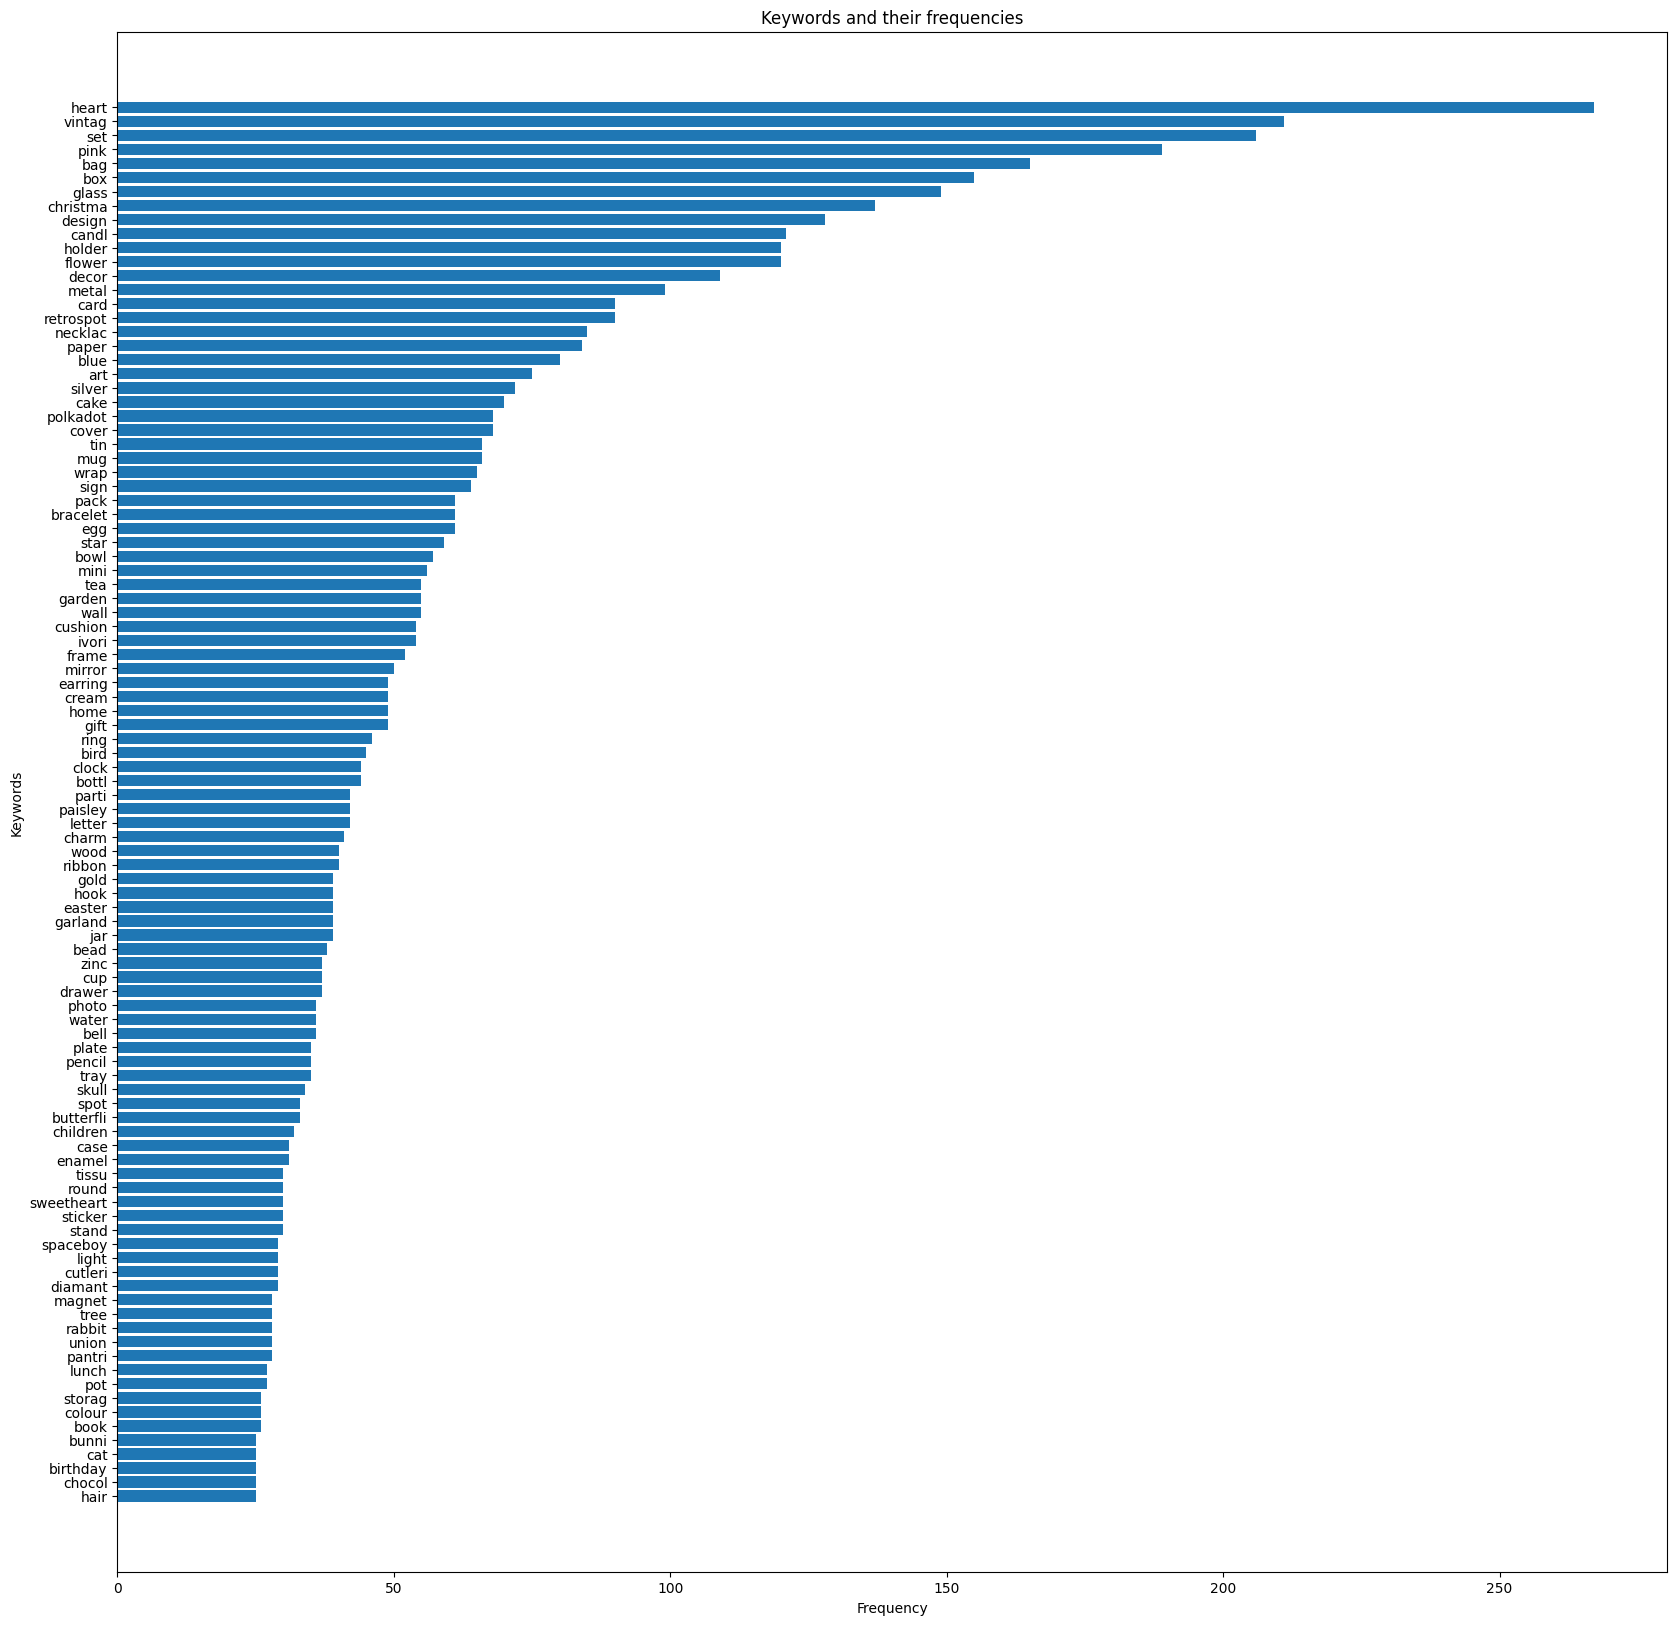

In [87]:
# sort the keywords by their frequencies after converting the count_keywords column to integer  
keywords = keywords.withColumn("count_keywords", keywords["count_keywords"].cast("int")).sort("count_keywords", ascending=False)
keywords.show()

# plot the histogram of the keywords frequencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# convert the PySpark DataFrame to Pandas DataFrame
keywords_pd = keywords.toPandas()

# plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(keywords_pd['category_key'][:100], keywords_pd['count_keywords'][:100])
ax.set_xlabel('Frequency')
ax.set_ylabel('Keywords')
ax.set_title('Keywords and their frequencies')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

